In [ ]:
# | hide
import nbdev
from nbdev.showdoc import *
nbdev.nbdev_export()

# Tidy Tensors

In [ ]:
# | default_exp tensor

In [ ]:
#| export
import numpy as np

In [ ]:
#| exporti
def calculate_target_shape(s1, s2):
    """Calculate the target shape for broadcasting two tensors"""

    # expand shaped to be the same length. Note (1,) * <negative> is empty
    s2 = (1,) * (len(s1) - len(s2)) + s2
    s1 = (1,) * (len(s2) - len(s1)) + s1

    out_shape = ()
    for dims in list(zip(reversed(s1), reversed(s2))):
        if dims[0] != 1 and dims[1] != 1 and dims[0] != dims[1]:
            raise ValueError(f"Cannot broadcast {s1} and {s2}")
        out_shape = (max(dims),) + out_shape

    return out_shape

In [ ]:
#| exporti

def maybe_broadcast_elementwise(a, b):
    """Broadcast two tensors if they have different shapes"""
    if a.data.shape != b.data.shape:
        target_shape = calculate_target_shape(a.data.shape, b.data.shape)
        # print(
        #     f"Elementwise broadcasted {a.data.shape} and {b.data.shape} to {target_shape}"
        # )
        a = a.broadcast(target_shape)
        b = b.broadcast(target_shape)

    return a, b


def maybe_broadcast_matmul(a, b):
    """Broadcast two tensors if they have different shapes, except for the last two dimensions"""

    a_short_shape = a.data.shape[:-2]
    b_short_shape = b.data.shape[:-2]

    if a_short_shape != b_short_shape:
        target_shape = calculate_target_shape(a_short_shape, b_short_shape)
        print(
            f"Matmul broadcasted {a.data.shape} and {b.data.shape} to {target_shape + a.data.shape[-2:]}"
        )
        a = a.broadcast(target_shape + a.data.shape[-2:])
        b = b.broadcast(target_shape + b.data.shape[-2:])

    return a, b

In [ ]:
# | exports

class Tensor:
    op = "L"
    name: str = ""
    parents: list = []

    def __init__(self, data, name=""):
        self.data = data
        self.name = name
        self.grad = np.zeros_like(self.data)

    def broadcast(self, target_shape):
        self_shape = self.data.shape
        if self_shape == target_shape:
            return self

        if len(self_shape) < len(target_shape):
            expanded_shape = (len(target_shape) - len(self_shape)) * (1,) + self_shape
        else:
            expanded_shape = self_shape

        final_shape = ()
        broadcasted_dims = ()

        for s_expanded, s_target in reversed(list(zip(expanded_shape, target_shape))):
            if s_expanded != s_target:
                if s_expanded != 1:
                    raise ValueError(f"Cannot broadcast {self_shape} to {target_shape}")
                else:
                    broadcasted_dims = (True,) + broadcasted_dims
                    final_shape = (s_target,) + final_shape

            else:
                broadcasted_dims = (False,) + broadcasted_dims
                final_shape = (s_expanded,) + final_shape

        broadcasted_data = np.broadcast_to(self.data, final_shape)

        assert final_shape == broadcasted_data.shape

        out = BroadcastTensor(data=broadcasted_data, name=self.name + "_broadcasted")
        out.parents = [self]
        out.broadcasted_dims = broadcasted_dims
        return out

    def add(self, other, name):
        a, b = maybe_broadcast_elementwise(self, other)

        out = AddTensor(data=a.data + b.data, name=name)
        out.parents = [a, b]
        return out

    def sub(self, other, name):
        a, b = maybe_broadcast_elementwise(self, other)
        out = SubTensor(data=a.data - b.data, name=name)
        out.parents = [a, b]
        return out

    def mul(self, other, name):
        a, b = maybe_broadcast_elementwise(self, other)
        out = MulTensor(data=a.data * b.data, name=name)
        out.parents = [a, b]
        return out

    def mmul(self, other, name):
        a, b = maybe_broadcast_matmul(self, other)
        # a, b = self, other
        out = MatMulTensor(data=np.matmul(a.data, b.data), name=name)
        out.parents = [a, b]
        return out

    def sum(self, name):
        out = SumTensor(data=self.data.sum(), name=name)
        out.parents = [self]
        return out

    def sigmoid(self, name):
        out = SigmoidTensor(data=1 / (1 + np.exp(-self.data)), name=name)
        out.parents = [self]
        return out

    def backward(self):
        # Create a list of all parent nodes, in reverse order
        # Start with the current node
        visited = []
        nodes = []

        def walk(node):
            for p in node.parents:
                if p not in visited:
                    visited.append(p)
                    walk(p)
                    nodes.append(p)

        walk(self)
        nodes.append(self)

        # print(nodes)
        self.grad = np.ones_like(self.data)
        for n in nodes[::-1]:
            if hasattr(n, "_backward"):
                n._backward()

    def __repr__(self):
        value_repr = repr(self.data)
        if "\n" in value_repr:
            res = f"\n{self.name}=\n{str(self.data)}\n{self.name}.grad=\n{str(self.grad)}"
        else:
            res = f"{self.name}={str(self.data)} {self.name}.grad={str(self.grad)}"

        if self.parents:
            res += (
                f" {self.name}.parents=[" + ",".join([p.name for p in self.parents]) + "]"
            )

        return f"Tensor(shape=[{self.data.shape}])] op={self.op or ''} {res}"


class AddTensor(Tensor):
    op = "+"

    def _backward(self):
        self.parents[0].grad += self.grad
        self.parents[1].grad += self.grad


class SubTensor(Tensor):
    op = "-"

    def _backward(self):
        self.parents[0].grad += self.grad
        self.parents[1].grad -= self.grad


class MulTensor(Tensor):
    op = "*"

    def _backward(self):
        self.parents[0].grad += self.grad * self.parents[1].data
        self.parents[1].grad += self.grad * self.parents[0].data


class MatMulTensor(Tensor):
    op = "@"

    def _backward(self):
        # print(self.grad)
        self.parents[0].grad += np.matmul(self.grad, self.parents[1].data.T)
        self.parents[1].grad += np.matmul(self.parents[0].data.T, self.grad)


class SumTensor(Tensor):
    op = "sum"

    def _backward(self):
        self.parents[0].grad += self.grad


class SigmoidTensor(Tensor):
    op = "sigmoid"

    def _backward(self):
        self.parents[0].grad += self.grad * self.data * (1 - self.data)


class BroadcastTensor(Tensor):
    op = "broadcast"

    def _backward(self):
        axis = tuple([i for i, dim in enumerate(self.broadcasted_dims) if dim])
        summed = self.grad.sum(axis=axis, keepdims=True)

        if summed.shape != self.parents[0].data.shape:
            summed = summed.reshape(self.parents[0].data.shape)

        self.parents[0].grad += summed

In [ ]:
from fastcore.test import test_eq, test_fail

In [ ]:
test_eq(calculate_target_shape((1, 2, 3), (2, 3)), (1, 2, 3))
test_eq(calculate_target_shape((1, 2, 3), (2, 1)), (1, 2, 3))
test_eq(calculate_target_shape((1, 2, 3), (1, 3)), (1, 2, 3))
test_eq(calculate_target_shape((1, 2, 3), (1, 1)), (1, 2, 3))

test_eq(calculate_target_shape((1, 5), (3, 1)), (3, 5))

test_fail(calculate_target_shape, args=((1, 2, 3), (2, 2)), contains="Cannot broadcast")

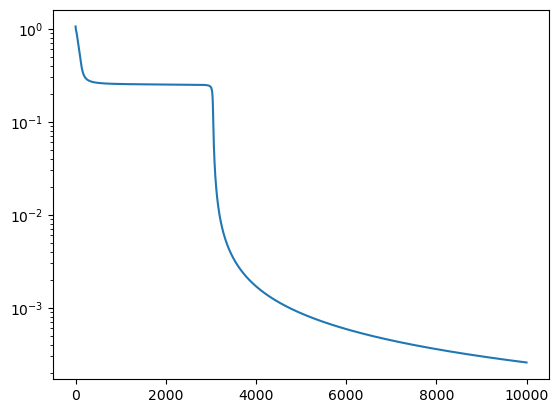

In [ ]:
import matplotlib.pyplot as plt

X = [
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1],
]

Y = [0, 1, 1, 0]

np.random.seed(1337)

w1 = Tensor(np.random.randn(2, 3) , "w1")
b1 = Tensor(np.zeros((1, 3)), "b1")

w2 = Tensor(np.random.randn(3, 1) , "w2")

LR = 1

losses = []

def NN(x, y, w1, b1, w2):
    z1 = x.mmul(w1, "z1").add(b1, "z1").sigmoid("z1")
    preds = z1.mmul(w2, "z2").sigmoid("preds")


    diff = preds.sub(y, "diff")

    l = diff.mul(diff, "l")
    loss = l.sum("loss")

    return loss, (diff, preds)

for i in range(10000):
    x = Tensor(np.array(X, dtype=float), "x")
    y = Tensor(np.array(Y, dtype=float)[:, None], "y")

    loss, debug_outs = NN(x, y, w1, b1, w2)

    loss.backward()

    w1.data -= LR * w1.grad
    b1.data -= LR * b1.grad
    w2.data -= LR * w2.grad

    w1.grad = np.zeros_like(w1.grad)
    b1.grad = np.zeros_like(b1.grad)
    w2.grad = np.zeros_like(w2.grad)

    losses.append(loss.data)

plt.plot(losses)
plt.yscale("log")

In [ ]:
test_eq(loss.data < 0.1, True)

In [ ]:
from tidygrad.utils import grad_check

In [ ]:
w1 = Tensor(np.random.randn(2, 3) * 0.1, "w1")
b1 = Tensor(np.zeros((1, 3)), "b1")

w2 = Tensor(np.random.randn(3, 1) * 0.1, "w2")

x = Tensor(np.array(X, dtype=float), "x")
y = Tensor(np.array(Y, dtype=float)[:, None], "y")

# z1 = Tensor(np.random.randn(4, 3), "fake_z1")

def NN(x, y, w1, b1, w2):
    z1 = x.mmul(w1, "z1").add(b1, "z1").sigmoid("z1")

    preds = z1.mmul(w2, "z2").sigmoid("preds")
    diff = preds.sub(y, "diff")
    l = diff.mul(diff, "l")

    loss = l.sum("loss")

    return loss


loss = NN(x, y, w1, b1, w2)
loss.backward()

grad_check([x, y, w1, b1, w2], NN)